In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from models import WeightedLasso
from utils.ode import lorenz, hydrogen_bromine, hydrogen_bromine_init, map_equation, rober, rober_init
import pandas as pd

from scipy.integrate import solve_ivp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
dt = 0.01
# x0_train = hydrogen_bromine_init
# x0_train = [1.28765293e-09, 7.25644133e-10, 1.65047091e-09, 8.16685447e-15, 1.66990500e-08, 1.00000000e-05]
# x0_train = rober_init
x0_train = [9.99902462e-01, 1.64381452e-05, 8.10998717e-05]
t_train = np.arange(0, 90, dt)
t_train_span = (t_train[0], t_train[-1])

data = solve_ivp(
    rober,
    t_train_span,
    x0_train,
    method='LSODA',
    rtol=1e-10,
    atol=1e-15,
    t_eval=t_train,
)

X = data.y.T

print("Generated X shape:", X.shape)
print("t_train shape:", t_train.shape)

combined_data = np.c_[t_train, X]
column_names = ['time', 'x0', 'x1', 'x2']

# 3. Create a pandas DataFrame
df = pd.DataFrame(combined_data, columns=column_names)

# 4. Save the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
df.to_csv('rober_ode_skip_stiff.csv', index=False)

Generated X shape: (9000, 3)
t_train shape: (9000,)


In [23]:
print(X[1000])

[9.99884780e-01 1.30479187e-05 1.02171867e-04]


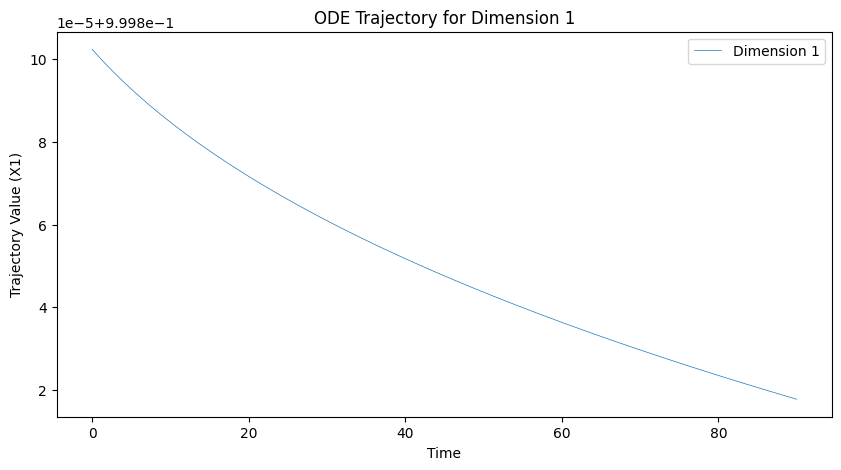

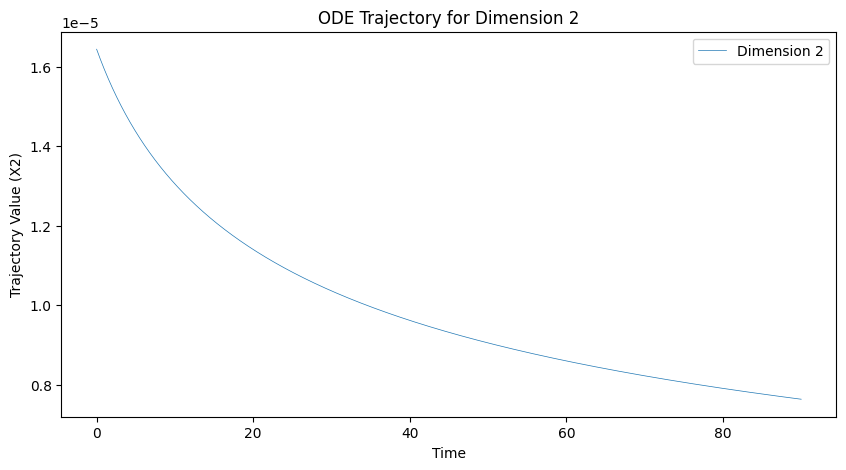

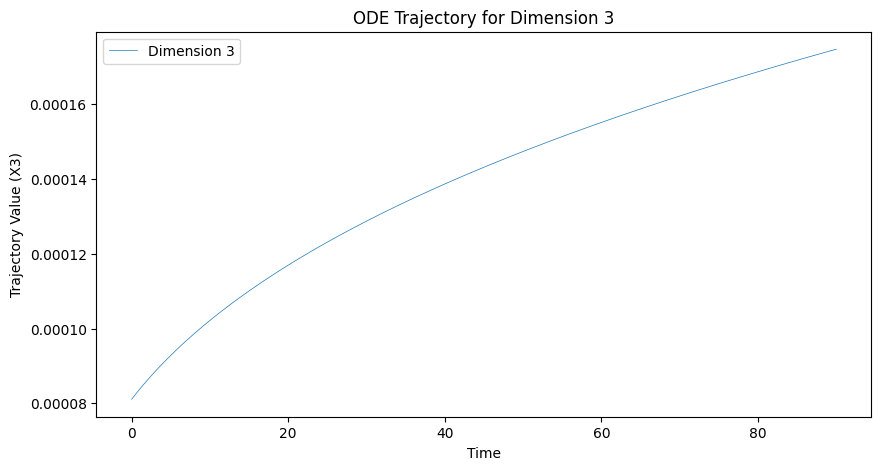

In [24]:
import matplotlib.pyplot as plt

for i in range(X.shape[1]):
    plt.figure(figsize=(10, 5))
    # plt.plot(t_train, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.plot(data.t, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.xlabel("Time")
    plt.ylabel(f"Trajectory Value (X{i+1})")
    plt.title(f"ODE Trajectory for Dimension {i+1}")
    plt.legend()
    plt.show()

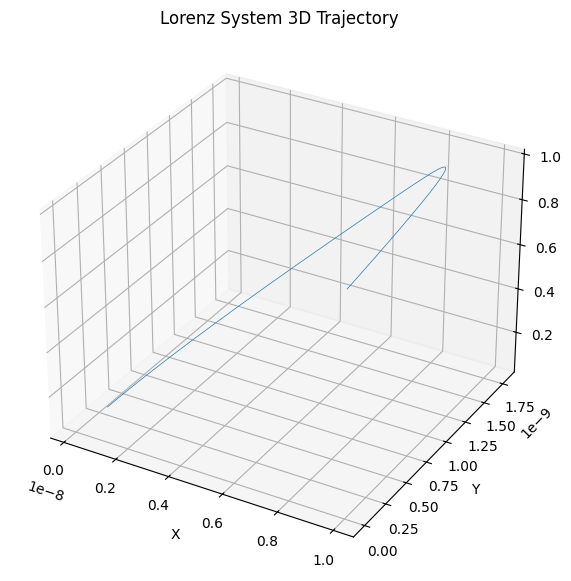

In [4]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Lorenz System 3D Trajectory")
plt.show()

In [5]:
# hydrogen_bromine(t_train, X.T), t_train.shape, X.shape
# for row in hydrogen_bromine(t_train, X.T):
#     print(len(row), row.shape)
# t_train.shape, X.shape

In [6]:
library = ps.PolynomialLibrary(degree=3)
library.fit(X)
true_coef = map_equation(hydrogen_bromine, library).T
model = ps.SINDy(
    feature_library=library,
    # optimizer=WeightedLasso(alpha=1e-4, weights=np.ones((library.size, 6)), max_iter=10000),
    optimizer=WeightedLasso(alpha=1e-4, weights=1/(np.abs(true_coef) + 1e-10), max_iter=10000),
    differentiation_method=ps.FiniteDifference(),
)


model.fit(x=X, t=t_train, x_dot=np.asarray(hydrogen_bromine(t_train, X.T)).T)
model.print()

(x0)' = -155224990517505.906 x0 x3 + 104.063 x0 x5 + 41.975 x1 x4 + -0.002 x0 x1 x3 + -77.371 x0 x3^2 + -0.011 x1^2 x3 + 244404638459263.750 x1^2 x5 + -0.002 x1 x2 x3 + -541.922 x1 x3^2 + -74.474 x2 x3^2 + -24749084.828 x3^3 + -72.648 x3^2 x4 + -0.057 x3^2 x5
(x1)' = 244532432302218.062 x0 x3 + 958.958 x0 x5 + 5511852523.177 x1 x2 + 667.155 x1 x4 + 159851700191094.438 x3 x4 + 0.002 x0^2 x3 + 0.001 x0 x1 x3 + 0.002 x0 x2 x3 + 220.420 x0 x3^2 + -0.008 x0 x3 x4 + -0.026 x1^2 x3 + -5915120363025014.000 x1^2 x5 + -331.946 x1 x3^2 + -0.019 x1 x3 x4 + 0.001 x2^2 x3 + 167.803 x2 x3^2 + -0.006 x2 x3 x4 + 21608565.768 x3^3 + -1363.541 x3^2 x4 + -0.272 x3^2 x5 + 0.001 x3 x4^2
(x2)' = -2609997023.702 x1 x2 + 13899951611974.320 x3 x4 + 0.121 x0 x3^2 + 0.461 x1 x3^2 + 0.108 x2 x3^2 + 21223.125 x3^3 + 0.039 x3^2 x4
(x3)' = 263930583.704 x0 x3 + 9693.816 x1 x2 + -352481078.982 x3 x4 + 0.030 x3^3
(x4)' = 120048940398709.078 x0 x3 + 2542000125.448 x1 x2 + 0.004 x1 x4 + -13539215758493.004 x3 x4 + -0.060

In [7]:
print(ps.__version__)

2.0.0


In [8]:
library.n_output_features_

84

In [9]:
model.coefficients()

array([[ 2.37361033e-34,  2.50995174e-25,  3.26118613e-25,
         2.00064585e-25,  8.10659494e-21,  1.16277443e-26,
         2.37360684e-29,  6.04649758e-17,  1.94828679e-17,
         5.00334004e-17, -1.55224991e+14,  8.65672443e-18,
         1.04063132e+02,  1.98923858e-17,  1.56586990e-17,
        -8.28388845e-12,  4.19745949e+01,  3.26116710e-20,
         4.11111015e-17, -1.05043277e-13,  8.11519942e-18,
         2.00065008e-20, -5.73563826e-07,  1.30052194e-12,
         8.10691769e-16,  6.30518213e-19,  1.16277288e-21,
         2.37351168e-24,  1.07159109e-08,  6.89318662e-09,
         9.21793260e-09,  2.99146574e-04, -2.86405596e-09,
         6.04651936e-12, -3.49071387e-08,  4.75670584e-09,
        -1.73321020e-03, -1.52414756e-09,  1.94815810e-12,
         7.86715098e-09,  2.04192065e-04, -2.17809419e-09,
         5.00331776e-12, -7.73705498e+01, -4.71245715e-04,
         1.52530782e-08,  9.65758852e-10,  8.65673198e-13,
         2.50994719e-15, -1.76133376e-07, -3.21890757e-0

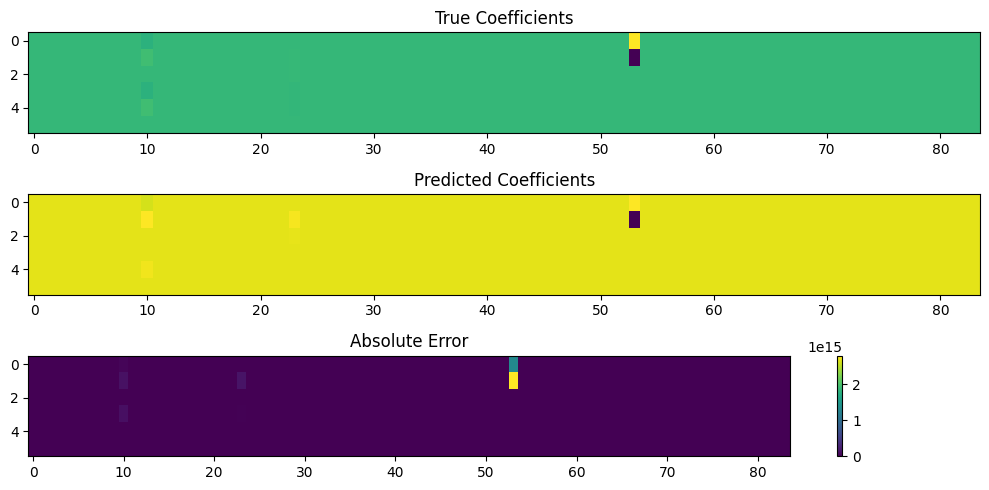

In [10]:
true_coef = map_equation(hydrogen_bromine, library)
pred_coef = model.coefficients()

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(true_coef, cmap='viridis', aspect='auto')
plt.title("True Coefficients")
plt.subplot(3, 1, 2)
plt.imshow(pred_coef, cmap='viridis', aspect='auto')
plt.title("Predicted Coefficients")
plt.subplot(3, 1, 3)
plt.imshow(np.abs(true_coef - pred_coef), cmap='viridis', aspect='auto')
plt.title("Absolute Error")
plt.colorbar()
plt.tight_layout()
plt.show()


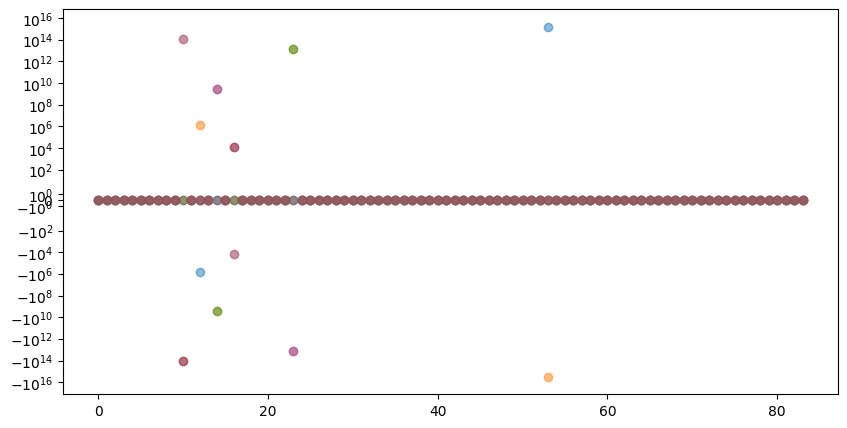

In [11]:
plt.figure(figsize=(10, 5))
for row in range(true_coef.shape[0]):
    plt.scatter(
        np.arange(true_coef.shape[1]),
        true_coef[row, :],
        label=f"True Coefficients Row {row}",
        alpha=0.5,
    )

plt.yscale('symlog')
plt.show()

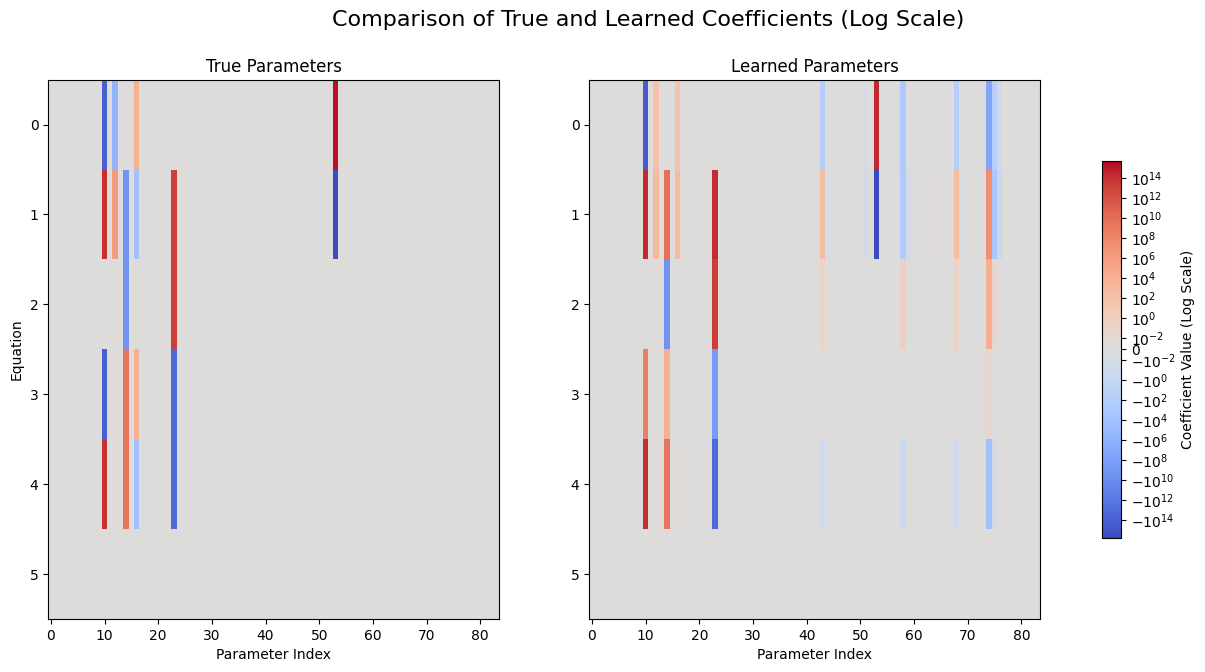

In [12]:
import matplotlib.colors as colors

true_coef = map_equation(hydrogen_bromine, library)
# true_coef = map_equation(hydrogen_bromine, library)
# pred_coef = model.coefficients()

# plt.figure(figsize=(10, 5))
# plt.subplot(3, 1, 1)
# plt.imshow(true_coef, cmap='viridis', aspect='auto')
# plt.title("True Coefficients")
# plt.subplot(3, 1, 2)
# plt.imshow(pred_coef, cmap='viridis', aspect='auto')
# plt.title("Predicted Coefficients")
# plt.subplot(3, 1, 3)
# plt.imshow(np.abs(true_coef - pred_coef), cmap='viridis', aspect='auto')
# plt.title("Absolute Error")
# plt.colorbar()
# plt.tight_layout()
# plt.show()

learned_coefficients = model.coefficients()
# learned_coefficients[np.abs(learned_coefficients) < 1e-4] = 0.0
# true_parameters[np.abs(true_parameters) < 1e-4] = 0.0 # Also clean true params for fairness

# Reshape from 1D vector (100,) to 2D column vector (100, 1) for imshow
# true_params_2d = true_parameters.reshape(-1, 1)
# learned_coeffs_2d = learned_coefficients.reshape(-1, 1)


# --- 3. Set up Shared Color Scale ---
# Find the maximum absolute value across BOTH arrays to center the color map
abs_max = max(np.abs(true_coef).max(), np.abs(learned_coefficients).max())

# Set vmin and vmax to be symmetric around zero.
vmin = -abs_max
vmax = abs_max

# Create the symmetric log normalizer
# linthresh: The range within which the plot is linear (-linthresh to +linthresh)
# A smaller value makes the log scale apply to smaller numbers.
linthresh = 1e-2
log_norm = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10)


# --- 4. Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparison of True and Learned Coefficients (Log Scale)', fontsize=16)

# Plot True Parameters
im1 = ax[0].imshow(
    true_coef,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the shared log normalization
)
ax[0].set_title('True Parameters')
ax[0].set_xlabel('Parameter Index')
ax[0].set_ylabel('Equation')
# ax[0].set_xticks([]) # Hide x-axis ticks as they are not meaningful

# Plot Learned Parameters
im2 = ax[1].imshow(
    learned_coefficients,
    aspect='auto',
    cmap='coolwarm',
    norm=log_norm  # Apply the SAME shared log normalization
)
ax[1].set_title('Learned Parameters')
ax[1].set_xlabel('Parameter Index')
# ax[1].set_xticks([])
# ax[1].set_yticks([]) # Hide y-axis ticks for the second plot

# Add a single, shared colorbar
fig.colorbar(im2, ax=ax, orientation='vertical', label='Coefficient Value (Log Scale)', shrink=0.7)

# plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
# plt.show()
plt.savefig('true_vs_learned_coefficients.png')

In [13]:
simulated_data = model.simulate(X[0], t_train)

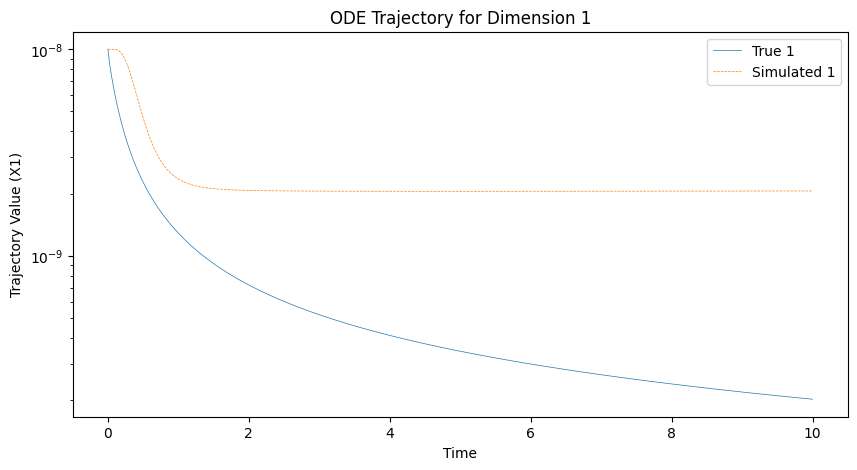

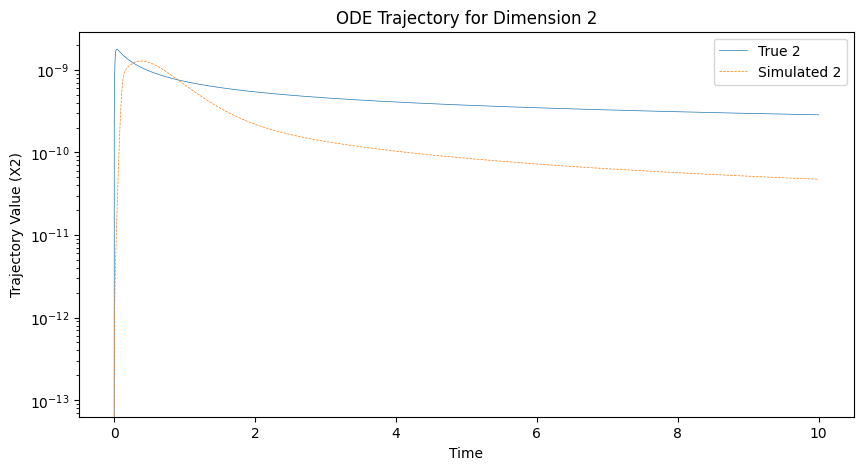

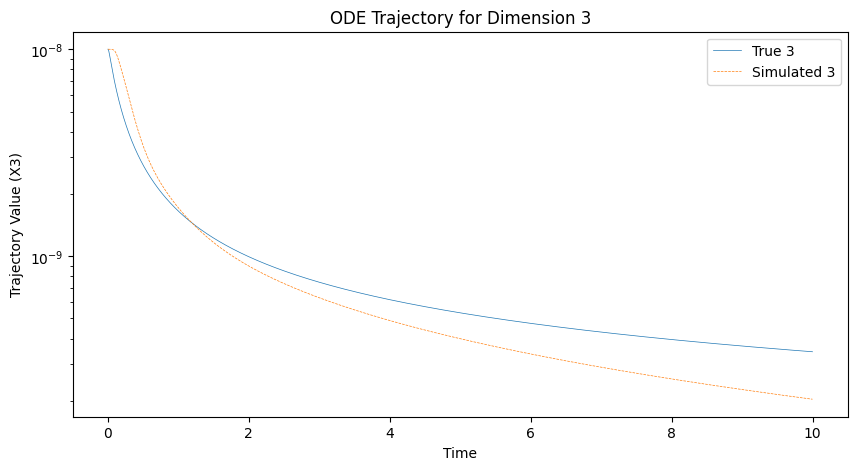

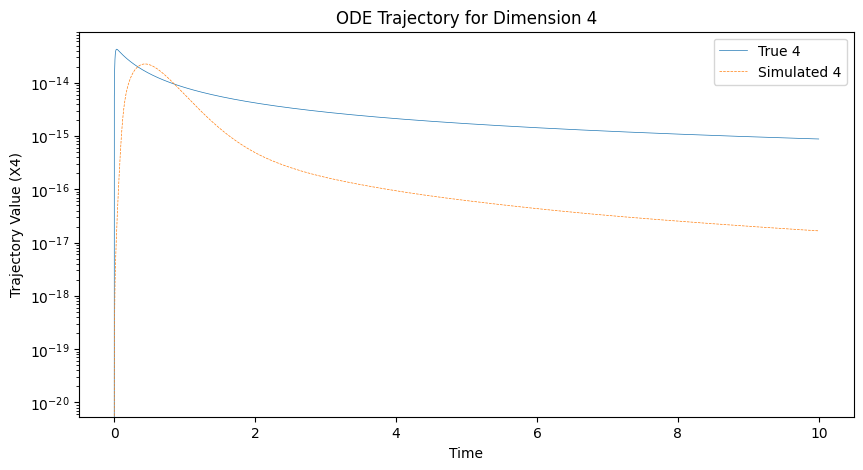

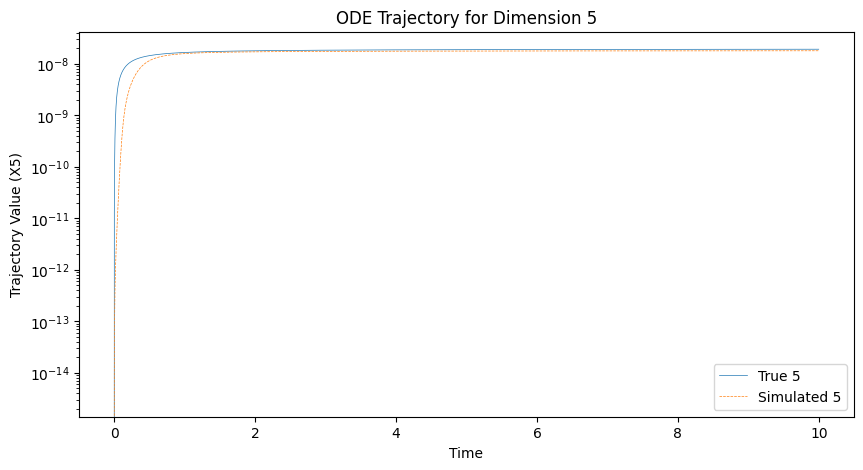

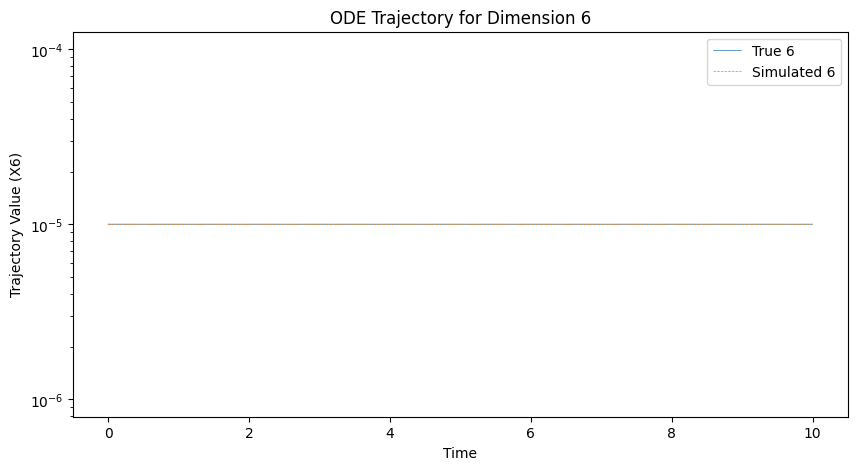

In [14]:
for i in range(X.shape[1]):
    plt.figure(figsize=(10, 5))
    # plt.plot(t_train, X[:, i], label=f"Dimension {i+1}", lw=0.5)
    plt.plot(data.t, X[:, i], label=f"True {i+1}", lw=0.5)
    plt.plot(t_train, simulated_data[:, i], label=f"Simulated {i+1}", lw=0.5, linestyle='--')
    plt.xlabel("Time")
    plt.ylabel(f"Trajectory Value (X{i+1})")
    plt.yscale('log')  # Use log scale for better visibility
    plt.title(f"ODE Trajectory for Dimension {i+1}")
    plt.legend()
    # plt.show()
    plt.savefig(f'trajectory_dimension_{i+1}.png')